## Посимвольная языковая модель.

В первом задании Вам нужно написать и обучить посимвольную нейронную языковую модель для вычисления вероятностей буквенных последовательностей (то есть слов). Такие модели используются в задачах словоизменения и распознавания/порождения звучащей речи. Для обучения модели используйте данные для русского языка из [репозитория](https://github.com/sigmorphon/conll2018/tree/master/task1/surprise).

**В процессе написания Вам нужно решить следующие проблемы:**
    
* как будет выглядеть обучающая выборка; что будет являться признаками, и что - метками классов.
* как сделать так, чтобы модель при предсказании символа учитывала все предыдущие символы слова.
* какие специальные символы нужно использовать.
* как передавать в модель текущее состояние рекуррентной сети

**Результаты:**

* предобработчик данных,
* генератор обучающих данных (батчей),
* обученная модель
* перплексия модели на настроечной выборке
* посимвольные вероятности слов в контрольной выборке

**Дополнительно:**

* дополнительный вход модели (часть речи слова, другие морфологические признаки), влияет ли его добавление на перплексию
* сравнение различных архитектур нейронной сети (FC, RNN, LSTM, QRNN, ...)

In [0]:
# it is better to do all imports at the first cell
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
import time
import math
from tqdm import tqdm_notebook

%matplotlib inline

In [2]:
# Uncomment to download data
!wget https://github.com/sigmorphon/conll2018/blob/master/task1/surprise/russian-train-high
!wget https://github.com/sigmorphon/conll2018/blob/master/task1/surprise/russian-dev
!wget https://github.com/sigmorphon/conll2018/blob/master/task1/surprise/russian-covered-test

--2019-04-13 17:12:52--  https://github.com/sigmorphon/conll2018/blob/master/task1/surprise/russian-train-high
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘russian-train-high.2’

russian-train-high.     [ <=>                ]   2.32M  --.-KB/s    in 0.1s    

2019-04-13 17:12:53 (19.8 MB/s) - ‘russian-train-high.2’ saved [2429266]

--2019-04-13 17:12:54--  https://github.com/sigmorphon/conll2018/blob/master/task1/surprise/russian-dev
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘russian-dev.2’

russian-dev.2           [ <=>                ] 284.45K  --.-KB/s    in 0.05s   

2019-04-13 17:12:54 (5.34 MB/s) - ‘russian-dev.2

### Препроцессинг

In [0]:
def read_dataset(infile):
    words, tags = [], []
    with open(infile, "r", encoding="utf8") as f:
        for line in f:
            line = line.strip()
            splitted = line.split("\t")
            if len(splitted) != 3 and len(splitted) != 2:
                continue
            words.append(splitted[0].split('>')[1].lower())
            tags.append(splitted[-1])
    return words, tags
train_words, train_tags = read_dataset("russian-train-high")
dev_words, dev_tags = read_dataset("russian-dev")
test_words, test_tags = read_dataset("russian-covered-test")

In [0]:
# UNK, START, END, PAD
AUXILIARY = ['?', '<', '>', '*']
start_token = '<'
end_token = '>'
pad_token_id = 3

Подумайте, какие вспомогательные токены могут быть вам полезны. Выдайте им индексы от `0` до `len(AUXILIARY) - 1`

In [0]:
class Vocabulary:
    def fit(self, data):
        """Extract unique symbols from the data, make itos ﴾item to string﴿ and stoi ﴾string to index﴿ objects"""
        symbols = set(x for elem in data for x in elem)
        self._symbols = AUXILIARY + sorted(symbols)
        # Запомните следующую строчку кода ­ она нужна примерно всегда
        self._symbol_codes = defaultdict(lambda: 0, {s: i for i, s in enumerate(self._symbols)})
        return self
      
    def __len__(self):
        return len(self._symbols)
      
    def transform(self, data):
        """Transform data to indices
        Input:
            - data, list of strings
        Output:
            - list of list of char indices
        >>> self.transform﴾['word1', 'token2']﴿
        >>> [[24, 2, 19, 13, 3], [8, 2, 9, 1, 7, 4]]
        """
        return [[self._symbol_codes[symbol] for symbol in string] for string in data]

In [0]:
def to_matrix(words_ids, pad=pad_token_id, max_len=None, dtype=np.int32):
    """Casts a list of names into rnn­digestable padded matrix"""
    
    max_len = max_len or max(map(len, words_ids)) + 1
    matrix = np.zeros([len(words_ids), max_len], dtype) + pad
    for i, word_ids in enumerate(words_ids):
        matrix[i, :len(word_ids)] = word_ids
    return matrix

In [0]:
def wrap_words(words):
    return [start_token + word + end_token for word in words]

In [25]:
voc = Vocabulary()
voc.fit(train_words)

In [26]:
to_matrix(voc.transform(wrap_words(train_words[:3])))

array([[ 1,  8,  6, 17, 17, 20, 19, 23, 16, 14, 15,  2,  3,  3,  3,  3],
       [ 1, 19, 11, 13,  6, 16, 20, 19, 29, 11, 19, 19, 33, 15,  2,  3],
       [ 1, 14, 23, 24, 22, 38, 21, 33,  8,  6, 24, 34,  2,  3,  3,  3]],
      dtype=int32)

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, inp, hidden):
        input_combined = torch.cat((inp, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
      
    def initHidden(self):
        return torch.randn(1, self.hidden_size)

In [0]:
voc = Vocabulary()
voc.fit(train_words)
def randomTrainingWord():
    word = np.random.choice(train_words)
    wrapped = wrap_words([word])
    return to_matrix(voc.transform(wrapped))[0]

In [29]:
randomTrainingWord().shape

(16,)

In [0]:
n_letters = len(voc)
# One-hot matrix of first to last letters ﴾not including EOS﴿ for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    tensor[np.arange(len(line)), 0, line] = 1
    return tensor[:-1, :, :]
# LongTensor of second letter to end ﴾EOS﴿ for target
def targetTensor(line):
    return torch.LongTensor(line[1:])

In [31]:
inputTensor(randomTrainingWord()).shape, targetTensor(randomTrainingWord()).shape

(torch.Size([8, 1, 39]), torch.Size([10]))

In [0]:
def inputOutputTensors(line):
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor
# Make input, and target tensor, line pair
def randomTrainingExample():
    line = randomTrainingWord()
    return inputOutputTensors(line)
def trainingExample(word):
    wrapped = wrap_words([word])
    line = to_matrix(voc.transform(wrapped))[0]
    return inputOutputTensors(line)

### Обучение

In [0]:
criterion = nn.NLLLoss()
learning_rate = 0.005
def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    return output, loss.item() / input_line_tensor.size(0)

In [0]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [35]:
rnn = RNN(len(voc), 128, len(voc))
n_iters = 10000
print_every = 500
plot_every = 50
all_losses = []
total_loss = 0 # Reset every plot_every iters
start = time.time()
for iter in tqdm_notebook(range(1, n_iters + 1)):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 3s (500 5%) 2.4837
0m 6s (1000 10%) 2.2915
0m 9s (1500 15%) 2.3939
0m 13s (2000 20%) 2.5319
0m 16s (2500 25%) 1.9756
0m 19s (3000 30%) 1.9734
0m 23s (3500 35%) 2.5258
0m 26s (4000 40%) 2.4418
0m 29s (4500 45%) 2.2195
0m 33s (5000 50%) 1.7525
0m 36s (5500 55%) 2.5504
0m 39s (6000 60%) 2.7199
0m 43s (6500 65%) 1.8523
0m 46s (7000 70%) 2.7025
0m 50s (7500 75%) 1.6703
0m 53s (8000 80%) 2.2299
0m 57s (8500 85%) 2.4103
1m 0s (9000 90%) 3.4682
1m 3s (9500 95%) 2.9642
1m 7s (10000 100%) 1.6071


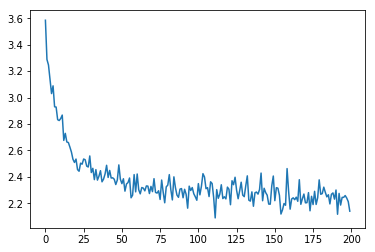

In [37]:
plt.figure()
plt.plot(all_losses)
plt.show()

### Перплексия

In [0]:
def get_perplexity(model, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()
    n = input_line_tensor.size(0)
    loss = 0
    for i in range(n):
        output, hidden = model(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    return 2 ** (loss / n)
  
  
def get_mean_perplexity(model, words):
    mean_perplexity = 0
    for word in tqdm_notebook(words):
        mean_perplexity += get_perplexity(model, *trainingExample(word))
    mean_perplexity /= len(words)
    return mean_perplexity

In [39]:
print(f"perplexity of random model = {2 ** (np.log(len(voc)))}")

perplexity of random model = 12.671906110334948


In [40]:
print(f"train perplexity = {get_mean_perplexity(rnn, train_words)}")

train perplexity = 5.014182090759277


In [41]:
print(f"validate perplexity = {get_mean_perplexity(rnn, dev_words)}")

validate perplexity = 5.0514984130859375


In [0]:
def get_tensor_probability(model, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = model.initHidden()
    n = input_line_tensor.size(0)
    prob = 1
    for i in range(n):
        output, hidden = model(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        prob *= np.e ** (-l)
    
    return prob
def get_words_probabilities(model, words):
    probs = np.zeros(len(words))
    for i, word in enumerate(tqdm_notebook(words)):
        probs[i] = get_tensor_probability(model, *trainingExample(word))
    return probs

In [44]:
test_probs = get_words_probabilities(rnn, test_words)

In [0]:
test_words_and_probs = list(zip(test_words, test_probs))

In [46]:
print("Самые невероятные слова")
sorted(test_words_and_probs, key=lambda x: x[1])[:10]

Самые невероятные слова


[('советская социалистическая республика', 1.401298464324817e-45),
 ('уменьшительно-ласкательное слово', 1.2611686178923354e-44),
 ('артиллерия дальнего действия', 4.3443856533719573e-38),
 ('мочеиспускательный канал', 8.557404917418367e-32),
 ('тяжёлая промышленность', 1.216152702076834e-31),
 ('однорядный роликовый конёк', 5.396409154596742e-31),
 ('амплитудная модуляция', 2.3590503359420623e-30),
 ('электронное сообщение', 1.7879887028685243e-28),
 ('трёхэтажное слово', 1.8903688516703408e-28),
 ('равносторонний треугольник', 3.9155800032082525e-28)]

In [47]:
print("Самые вероятные слова")
sorted(test_words_and_probs, key=lambda x: x[1], reverse=True)[:10]

Самые вероятные слова


[('виться', 0.00041891407454386353),
 ('винный', 2.054999458778184e-05),
 ('устный', 1.7770349586498924e-05),
 ('ум', 1.4592837942473125e-05),
 ('гой', 7.99982990429271e-06),
 ('сраный', 7.34308969185804e-06),
 ('иней', 3.4121439966838807e-06),
 ('родительный', 3.3428163987991866e-06),
 ('супить', 3.0140342914819485e-06),
 ('копить', 2.0880706870229915e-06)]

Как видим, самые невероятные слова - длинные слова (ведь это посимвольное произведение) или слова
с редкими буквами (например ' ').